# Hand Sign Recognition Machine Learning
this is a machine learning file that is used to train the model for a hand sign recognition system. for now, the dataset is only for the signs are only using the alphabet signs. However, for the future, we can add kind of words sign to the dataset.

## Chores

### Import Necessary Libraries

In [10]:
import os
import zipfile
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import csv
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
try:
    import kaggle
except (OSError, ModuleNotFoundError):
    print("Kaggle API not found. Please run 'pip install kaggle' and set up your kaggle.json.")
    raise


### Download Datasets
The dataset used in this project are indonesian sign language [SIBI dataset](https://www.kaggle.com/datasets/alvinbintang/sibi-dataset). Then, the we also use american dataset [ASL dataset](https://www.kaggle.com/datasets/ashwinjayan/asn-dataset) for training the model.

hopefully using both dataset would make the model more accurate to identify more kinds of sign language

In [12]:
DATA_ROOT = "data"
os.makedirs(DATA_ROOT, exist_ok=True)


KAGGLE_SIBI = "alvinbintang/sibi-dataset"
SIBI_FOLDER = os.path.join(DATA_ROOT, "SIBI_Alphabet_Dataset")
SIBI_MAIN_PATH = os.path.join(SIBI_FOLDER, "SIBI")

if not os.path.exists(SIBI_FOLDER):
    print(f"Downloading SIBI Dataset: '{KAGGLE_SIBI}'...")
    kaggle.api.dataset_download_files(KAGGLE_SIBI, path=DATA_ROOT, unzip=False, quiet=False)
    with zipfile.ZipFile(os.path.join(DATA_ROOT, "sibi-dataset.zip"), 'r') as z:
        z.extractall(SIBI_FOLDER)
    os.remove(os.path.join(DATA_ROOT, "sibi-dataset.zip"))
    print("SIBI Dataset ready.")
else:
    print(f"SIBI Dataset already exists at '{SIBI_FOLDER}'.")

KAGGLE_ASL_TRAIN = "grassknoted/asl-alphabet"
ASL_TRAIN_FOLDER = os.path.join(DATA_ROOT, "ASL_Alphabet_Train")
ASL_TRAIN_PATH = os.path.join(ASL_TRAIN_FOLDER, "asl_alphabet_train", "asl_alphabet_train")

if not os.path.exists(ASL_TRAIN_FOLDER):
    print(f"Downloading ASL Train Dataset: '{KAGGLE_ASL_TRAIN}'...")
    kaggle.api.dataset_download_files(KAGGLE_ASL_TRAIN, path=ASL_TRAIN_FOLDER, unzip=True, quiet=False)
    print("ASL Train Dataset ready.")
else:
    print(f"ASL Train Dataset already exists at '{ASL_TRAIN_FOLDER}'.")

print("All datasets are ready.")


SIBI Dataset already exists at 'data\SIBI_Alphabet_Dataset'.
ASL Train Dataset already exists at 'data\ASL_Alphabet_Train'.
All datasets are ready.


## Combine Datasets and Extrarct Landmarks
we use extracting landmarks rather than using the original dataset becuase we think that it would be more accurate and faster to use the coordinates of the landmarks rather than using pattern recognition to identify the sign 

In [13]:
TRAIN_CSV_FILE = os.path.join(DATA_ROOT, "train_landmarks.csv")
TEST_CSV_FILE = os.path.join(DATA_ROOT, "test_landmarks.csv")

def process_image_paths(image_paths, hands_processor):
    """Helper function to process a list of image paths and return landmark data."""
    processed_data = []
    for image_path in tqdm(image_paths, desc="Processing images"):
        label = os.path.basename(os.path.dirname(image_path)) # Extract label from parent folder
        image = cv2.imread(image_path)
        if image is None: continue
        
        results = hands_processor.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks:
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.multi_hand_landmarks[0].landmark]).flatten()
            processed_data.append([label.upper()] + list(landmarks))
    return processed_data

if not os.path.exists(TRAIN_CSV_FILE) or not os.path.exists(TEST_CSV_FILE):
    print("Starting data processing...")
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
    
    # Get all SIBI image paths and their labels
    sibi_image_paths = []
    sibi_labels = []

    # Identify all the classes
    valid_labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for label in sorted(os.listdir(SIBI_MAIN_PATH)):
        if label.upper() not in valid_labels: continue
        label_path = os.path.join(SIBI_MAIN_PATH, label)
        if not os.path.isdir(label_path): continue
        for img_file in os.listdir(label_path):
            sibi_image_paths.append(os.path.join(label_path, img_file))
            sibi_labels.append(label.upper())

    # Split SIBI paths into a training set and a dedicated test set
    sibi_train_paths, sibi_test_paths = train_test_split(
        sibi_image_paths, test_size=0.2, random_state=42, stratify=sibi_labels
    )
    
    # Process the SIBI test set
    print("\nProcessing SIBI test set...")
    test_data = process_image_paths(sibi_test_paths, hands)
    with open(TEST_CSV_FILE, 'w', newline='') as f:
        writer = csv.writer(f)
        headers = ['label'] + [f'{axis}{i}' for i in range(21) for axis in ['x', 'y', 'z']]
        writer.writerow(headers)
        writer.writerows(test_data)
    print(f"Test data saved to '{TEST_CSV_FILE}'")

    # Get all ASL image paths
    asl_train_paths = []
    for label in sorted(os.listdir(ASL_TRAIN_PATH)):
         if label.upper() not in valid_labels: continue
         label_path = os.path.join(ASL_TRAIN_PATH, label)
         if not os.path.isdir(label_path): continue
         for img_file in os.listdir(label_path):
             asl_train_paths.append(os.path.join(label_path, img_file))

    # Combine SIBI train paths and ASL train paths
    combined_train_paths = sibi_train_paths + asl_train_paths
    
    # Process the combined training set
    print("\nProcessing combined (SIBI + ASL) training set...")
    train_data = process_image_paths(combined_train_paths, hands)
    with open(TRAIN_CSV_FILE, 'w', newline='') as f:
        writer = csv.writer(f)
        headers = ['label'] + [f'{axis}{i}' for i in range(21) for axis in ['x', 'y', 'z']]
        writer.writerow(headers)
        writer.writerows(train_data)
    print(f"Training data saved to '{TRAIN_CSV_FILE}'")

    hands.close()
else:
    print(f"CSV files already exist. Skipping image processing.")

print("Raw data processing complete.")

CSV files already exist. Skipping image processing.
Raw data processing complete.


## EDA
This EDA will be used to analyze the dataset in order to build a better model.

### Data Overview

In [14]:
df_train = pd.read_csv(TRAIN_CSV_FILE)

# Data Overview and Integrity Check
print("\n1. Data Overview:")
print(df_train.info())
print(f"\nTotal missing values: {df_train.isnull().sum().sum()}")
print(f"Dataset shape: {df_train.shape}")


1. Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62283 entries, 0 to 62282
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   62283 non-null  object 
 1   x0      62283 non-null  float64
 2   y0      62283 non-null  float64
 3   z0      62283 non-null  float64
 4   x1      62283 non-null  float64
 5   y1      62283 non-null  float64
 6   z1      62283 non-null  float64
 7   x2      62283 non-null  float64
 8   y2      62283 non-null  float64
 9   z2      62283 non-null  float64
 10  x3      62283 non-null  float64
 11  y3      62283 non-null  float64
 12  z3      62283 non-null  float64
 13  x4      62283 non-null  float64
 14  y4      62283 non-null  float64
 15  z4      62283 non-null  float64
 16  x5      62283 non-null  float64
 17  y5      62283 non-null  float64
 18  z5      62283 non-null  float64
 19  x6      62283 non-null  float64
 20  y6      62283 non-null  float64
 21  z6      62283 no


Class Distribution:


C:\Users\Dave\AppData\Local\Temp\ipykernel_19348\585793617.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')


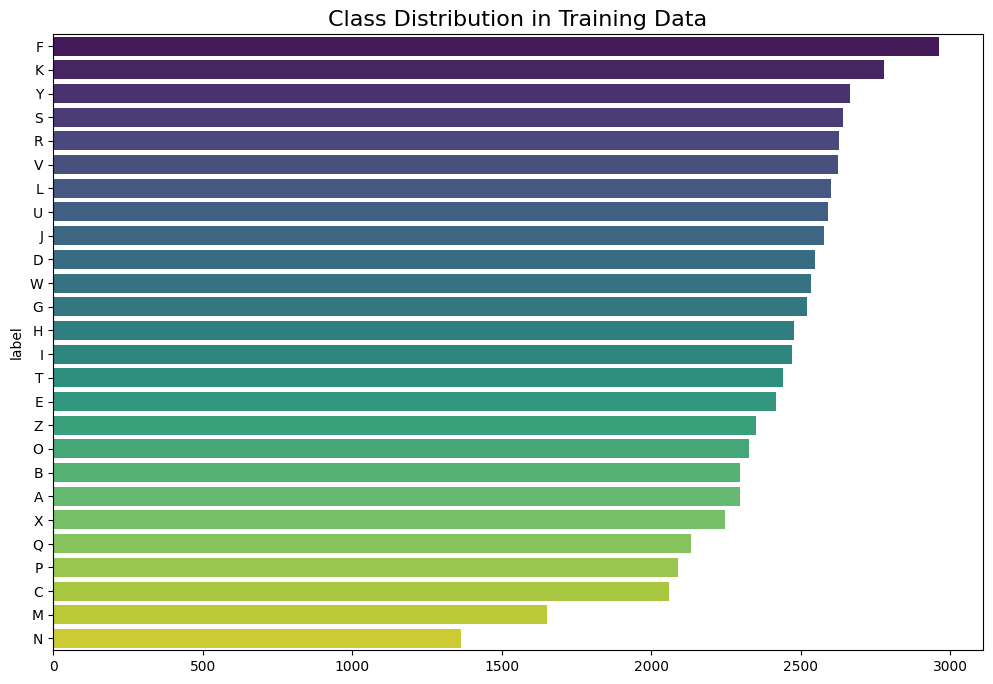

In [15]:
print("\nClass Distribution:")
class_counts = df_train['label'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')
plt.title('Class Distribution in Training Data', fontsize=16)
plt.show()

Based on the Overview, there is a chance that the data will be overfit for certain class rather than generalize well.

### Class Model Overview


PCA Visualization of Class Separability:


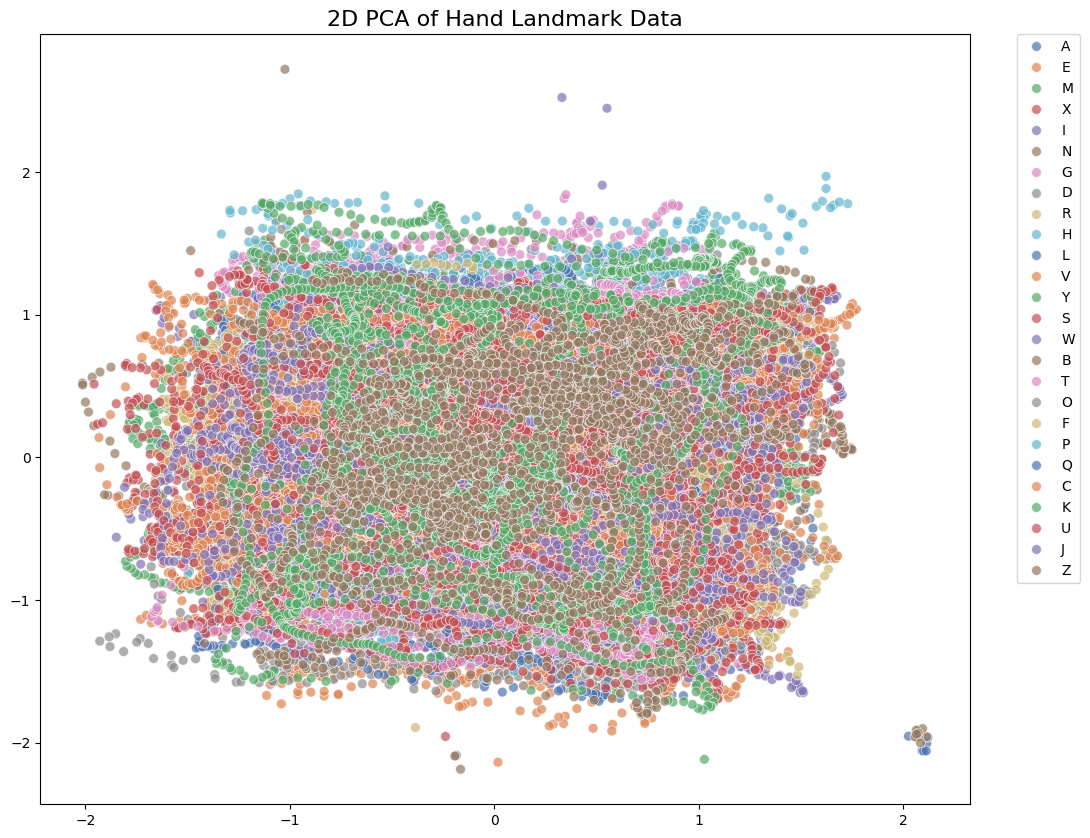

In [16]:
print("\nPCA Visualization of Class Separability:")
X_for_pca = df_train.drop('label', axis=1).values
y_for_pca = df_train['label'].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_pca)
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_for_pca, palette='deep', s=50, alpha=0.7)
plt.title('2D PCA of Hand Landmark Data', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Based on this class separability, the looks between each of the classes are close to each other. This means that the model is <b>complex</b>. and required <b>a neural network </b> to distinguish between the different classes.


4. Landmark Variation Analysis:


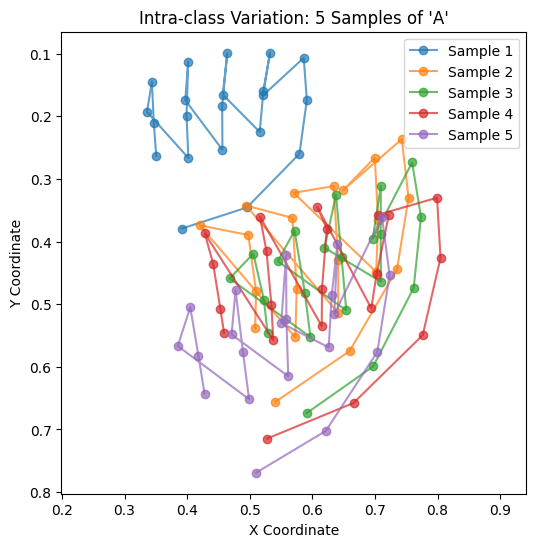

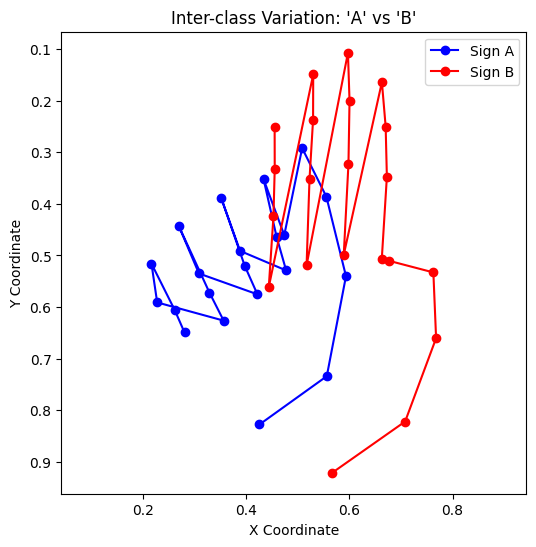

In [17]:

# Intra-class vs. Inter-class Variation Visualization
print("\n4. Landmark Variation Analysis:")
def plot_sign_samples(df, label, n_samples=5, title=""):
    plt.figure(figsize=(6, 6))
    samples = df[df['label'] == label].sample(n_samples)
    for index, row in samples.iterrows():
        landmarks = row.drop('label').values.reshape(21, 3)
        plt.plot(landmarks[:, 0], landmarks[:, 1], 'o-', alpha=0.7)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend([f"Sample {i+1}" for i in range(n_samples)])
    plt.axis('equal')
    plt.show()

# Intra-class variation for 'A'
plot_sign_samples(df_train, 'A', n_samples=5, title="Intra-class Variation: 5 Samples of 'A'")

# Inter-class variation for 'A' vs 'B'
plt.figure(figsize=(6, 6))
sample_a = df_train[df_train['label'] == 'A'].iloc[0].drop('label').values.reshape(21, 3)
sample_b = df_train[df_train['label'] == 'B'].iloc[0].drop('label').values.reshape(21, 3)
plt.plot(sample_a[:, 0], sample_a[:, 1], 'o-', color='blue', label='Sign A')
plt.plot(sample_b[:, 0], sample_b[:, 1], 'o-', color='red', label='Sign B')
plt.gca().invert_yaxis()
plt.title("Inter-class Variation: 'A' vs 'B'")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.axis('equal')
plt.show()

Intra-class Variation Insight :<br>
Samples for the same sign ('A') show variations in position and rotation, but the core shape is consistent. Our preprocessing needs to handle these variations.<br>

Inter-class Variation Insight :<br>
Samples for different signs ('A' and 'B') show variations in position and rotation, but the core shape is consistent. Our preprocessing needs to handle these variations.<br>

## Preprocessing
in this part based on the EDA, the model that we will use is the model that is using convolution network or CNN. In order to preprocess the dataset, we need to do the following steps:
1. Convert the dataset into an array of convolutional from 63 features into 21 landmarks and 3 coordinates. This is making sure that the model can be turned into a 3D model.
2. Separate the dataset into training and testing dataset. The training dataset will be used to train the model and the testing dataset will be used to test the model.

In [18]:

print("Preprocessing Data")

def preprocess_data(csv_file):
    """Loads, preprocesses, and reshapes landmark data for the CNN model."""
    df = pd.read_csv(csv_file)
    X = df.drop('label', axis=1).values
    y = df['label'].values
    
    X_processed = []
    for row in X:
        # Reshape the flat 63 features into (21 landmarks, 3 coordinates)
        landmarks = row.reshape(21, 3)
        
        # Normalize landmarks
        wrist = landmarks[0]
        relative_landmarks = landmarks - wrist
        max_dist = np.max(np.linalg.norm(relative_landmarks, axis=1))
        if max_dist == 0: max_dist = 1 # Avoid division by zero
        normalized_landmarks = relative_landmarks / max_dist
        
        X_processed.append(normalized_landmarks)
    
    return np.array(X_processed), y

# Preprocess data, ensuring it's in the correct 3D shape for the CNN
X_train_full, y_train_full = preprocess_data(TRAIN_CSV_FILE)
X_test, y_test_labels = preprocess_data(TEST_CSV_FILE)

# Encode labels
label_encoder = LabelEncoder()
y_train_full_encoded = label_encoder.fit_transform(y_train_full)
y_test_encoded = label_encoder.transform(y_test_labels)

# Create a validation split from the training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full_encoded, test_size=0.2, random_state=42, stratify=y_train_full_encoded
)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")
print("Preprocessing complete.")

Preprocessing Data
Training features shape: (49826, 21, 3)
Validation features shape: (12457, 21, 3)
Test features shape: (521, 21, 3)
Preprocessing complete.


## Modeling
Before this, we have actually try to use an FFNN to process the data. But it was not working well. Especially it is hard for them to identify between sign that are so similar to each other. 
After doing some analysis in the dataset and based on the error analysis. we decided to use a CNN in order to process the landmarks 3D and produce a recignition based on the pattern.

In [19]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(21, 3)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
]

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

print("Model training complete.")

d:\Work\Lomba\WADBS-Emergensee\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 19, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,978 (304.60 KB)

 Trainable params: 77,978 (304.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7961 - loss: 0.6816 - val_accuracy: 0.9520 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 2/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9455 - loss: 0.2033 - val_accuracy: 0.9683 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 3/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9588 - loss: 0.1538 - val_accuracy: 0.9756 - val_loss: 0.0908 - learning_rate: 0.0010
Epoch 4/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9656 - loss: 0.1231 - val_accuracy: 0.9780 - val_loss: 0.0825 - learning_rate: 0.0010
Epoch 5/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9708 - loss: 0.1078 - val_accuracy: 0.9814 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 6/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9743 - loss: 0.0938 - val_accuracy: 0.9811 - val_loss: 0.0663 - learning_rate: 0.0010
Epoch 7/100
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9

## Model Validation
This is used to validate the model's performance on the dataset.

In [20]:
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"\nModel Accuracy on Test Set: {accuracy * 100:.2f}%")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

present_labels = np.unique(np.concatenate((y_test_encoded, y_pred)))
present_target_names = label_encoder.inverse_transform(present_labels)

print("\nClassification Report on Test Set:")
print(classification_report(y_test_encoded, y_pred, labels=present_labels, target_names=present_target_names))

print("Validation complete.")


Model Accuracy on Test Set: 96.35%
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        29
           B       1.00      1.00      1.00        29
           C       1.00      0.81      0.90        16
           D       0.93      1.00      0.96        26
           E       0.95      1.00      0.98        21
           F       1.00      1.00      1.00        24
           G       0.95      1.00      0.98        21
           H       1.00      0.95      0.98        22
           I       1.00      0.91      0.95        23
           J       0.00      0.00      0.00         0
           K       0.91      1.00      0.95        20
           L       1.00      1.00      1.00        29
           M       1.00      0.96      0.98        23
           N       1.00      1.00      1.00        21
           O       0.96      1.00      0.98        24
           P       1.00 

d:\Work\Lomba\WADBS-Emergensee\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Work\Lomba\WADBS-Emergensee\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Work\Lomba\WADBS-Emergensee\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Extract To Model
This model that is extracted will be used in the application later.

In [21]:
print("Exporting Artifacts")
MODELS_ROOT = os.path.join("..", "models")
os.makedirs(MODELS_ROOT, exist_ok=True)

MODEL_FILE = os.path.join(MODELS_ROOT, 'sibi_asl_robust_model.h5')
ENCODER_FILE = os.path.join(MODELS_ROOT, 'sibi_asl_robust_encoder.pkl')

model.save(MODEL_FILE)
with open(ENCODER_FILE, 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"Model saved to '{MODEL_FILE}'")
print(f"Label encoder saved to '{ENCODER_FILE}'")
print("Export complete.")

Exporting Artifacts
Model saved to '..\models\sibi_asl_robust_model.h5'
Label encoder saved to '..\models\sibi_asl_robust_encoder.pkl'
Export complete.
